# Домашнее задание 6: классификация текстов

В этом домашнем задании вам предстоит построить классификатор текстов!

Данные мы будем использовать из Kaggle соревнования: https://www.kaggle.com/competitions/nlp-getting-started/data 


Оттуда надо скачать файл train.csv. На обучающую и тестовую выборки его поделим кодом ниже, менять его не надо!

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [1]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

## Задание 1 (0.5 балла)

Выведете на экран информацию о пропусках в данных. Если пропуски присутствуют заполните их пустой строкой.

In [5]:
train.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [6]:
test.isnull().any()

id          False
keyword      True
location     True
text        False
target      False
dtype: bool

In [7]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)
print(train.isnull().any().any())
print(test.isnull().any().any())

False
False


## Задание 2 (1 балл)
Давайте немного посмотрим на наши данные. Визуализируйте (где явно просят) или выведете информацию о следующем:

1. Какое распределение классов в обучающей выборке?


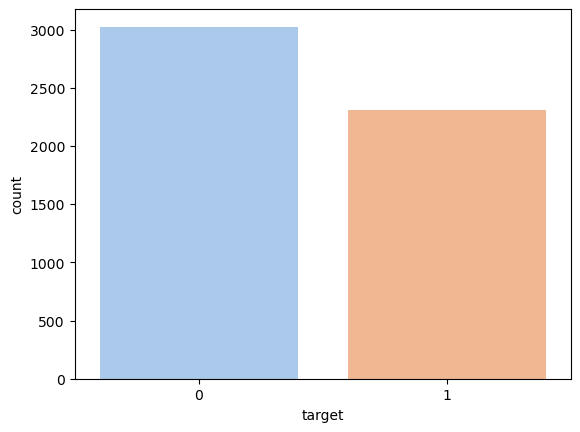

In [8]:
sns.countplot(x=train['target'], palette='pastel')
plt.show()

2. Посмотрите на колонку "keyword" - возьмите 10 наиболее встречающихся значений, постройте ступенчатую диаграмму распределения классов в зависимости от значения keyword, сделайте выводы.

In [9]:
train['keyword']

1186    bridge%20collapse
4071                 hail
5461               police
5787              rioting
7445               wounds
              ...        
5226         obliteration
5390                panic
860                 blood
7603                     
7270            whirlwind
Name: keyword, Length: 5329, dtype: object

In [10]:
train['keyword'].value_counts().idxmax()

''

самое часто встречающееся значение - пустая строка, поэтому возьмем первые 10 значений, начиная с первого индекса, а не с нулевого

In [11]:
popular_keywords = train['keyword'].value_counts()[1:11].index.tolist()
popular_keywords

['damage',
 'siren',
 'wreckage',
 'fatalities',
 'deluge',
 'refugees',
 'derail',
 'fear',
 'tsunami',
 'fatality']

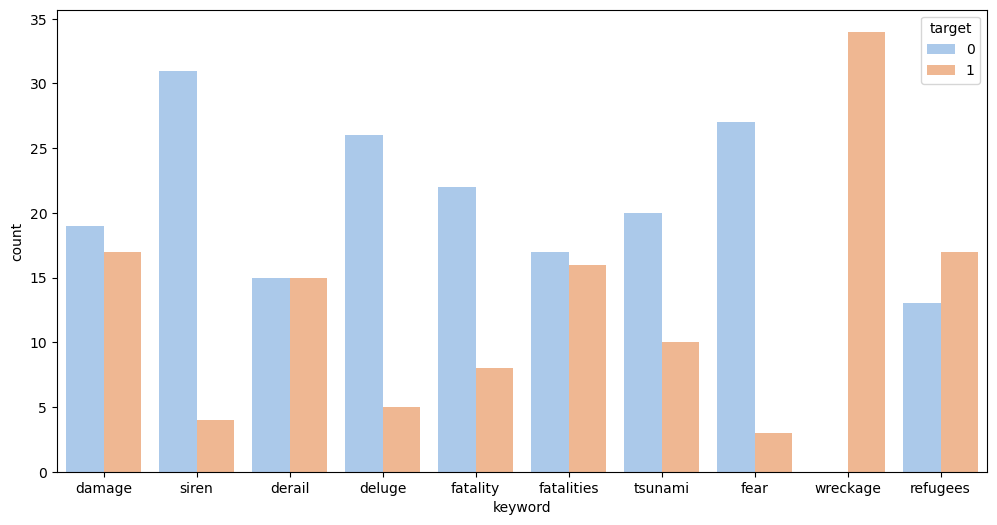

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train[train['keyword'].isin(popular_keywords)], x='keyword', hue='target', palette='pastel')
plt.show()

**Выводы**: 
Посмотрим на столбцы гистограммы, которые указывают на большую разницу в целевой переменной для разных значений признака "keyword". Тексты, в которых ключевое слово - "siren" / "deluge" / "fatality" / "tsunami" / "fear" в большинстве случаев не содержат информации о катастрофе, тогда как тексты с ключевым словом "wreckage" почти всегда содержат информацию о катастрофе. 

## Задание 3 (0.5 балла) 

В этом задании предлагается объединить все три текстовых столбца в один (просто сконкатенировать cтроки) и убрать столбец с индексом.

In [13]:
train.loc[[6590, 7122, 2769]]

,id,keyword,location,text,target
6590,9436,survivors,"Marietta, GA",Stemming from my #Cubs talk- the team rosters ...,1
7122,10203,violent%20storm,,If you were the NWS wth a rotating storm w/ a ...,1
2769,3980,devastation,Atlanta g.a.,http://t.co/Gxgm1T3W0J From Devastation to Ela...,0


In [14]:
train['text'] = train[['keyword', 'location', 'text']].agg(' '.join, axis=1)
train.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

In [15]:
train.loc[[6590, 7122, 2769]]

,text,target
6590,"survivors Marietta, GA Stemming from my #Cubs ...",1
7122,violent%20storm If you were the NWS wth a rot...,1
2769,devastation Atlanta g.a. http://t.co/Gxgm1T3W0...,0


## Задание 4 (0.5 балла)

Далее мы будем пока работать только с train частью.

1. Предобработайте данные (train часть) с помощью CountVectorizer.
2. Какого размера получилась матрица?


In [16]:
text = train['text'].tolist()
text

['bridge%20collapse  Ashes 2015: Australia\x89Ûªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0',
 'hail Carol Stream, Illinois GREAT MICHIGAN TECHNIQUE CAMP\nB1G THANKS TO @bmurph1019 \n@hail_Youtsey . @termn8r13 \n#GoBlue #WrestleOn http://t.co/OasKgki6Qj',
 'police Houston  CNN: Tennessee movie theater shooting suspect killed by police http://t.co/dI8ElZsWNR',
 'rioting  Still rioting in a couple of hours left until I have to be up for class.',
 'wounds Lake Highlands Crack in the path where I wiped out this morning during beach run. Surface wounds on left elbow and right knee. http://t.co/yaqRSximph',
 'airplane%20accident Somewhere Out There Experts in France begin examining airplane debris found on Reunion Island: French air accident experts on... http://t.co/TagZbcXFj0 #MLB',
 "bloody Isolated City In World Perth 'I came to kill Indians...for FUN': Video of smirking and remorseless Pakistani killer shows him boas

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

cnt_vec = CountVectorizer() 
X = cnt_vec.fit_transform(text)
train_vectorized = pd.DataFrame(X.toarray(), columns=cnt_vec.get_feature_names())
train_vectorized.head()

C:\Users\huawei\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,00cy9vxeff,00end,00pm,01,011072,014213,02,...,ûïthe,ûïwe,ûïwhen,ûïyou,ûò,ûò800000,ûó,ûóher,ûókody,ûótech
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
train_vectorized.shape

(5329, 18455)

## Задание 5 (1 балл)

В предыдущем пункте у вас должна была получиться достаточно большая матрица.
Если вы взгляните на текст, то увидете, что там есть множество специальных символов, ссылок и прочего мусора.

Давайте также посмотрим на словарь, который получился в результате построения CountVectorizer, его можно найти в поле vocabulary_ инстанса этого класса. Давайте напишем функцию, которая печает ответы на следующие вопросы:

1. Найдите в этом словаре все слова, которые содержат цифры. Сколько таких слов нашлось?

2. Найдите все слова, которые содержат символы пунктуации. Сколько таких слов нашлось? 

3. Сколько хэштегов (токен начинается на #) и упоминаний (токен начинается на @) осталось в словаре?

In [19]:
cnt_vec.vocabulary_

{'bridge': 2948,
 '20collapse': 320,
 'ashes': 1928,
 '2015': 295,
 'australia': 2059,
 'ûªs': 18425,
 'collapse': 3914,
 'at': 1977,
 'trent': 16483,
 'among': 1628,
 'worst': 17813,
 'in': 8314,
 'history': 7773,
 'england': 5722,
 'bundled': 3085,
 'out': 11995,
 'for': 6503,
 '60': 755,
 'http': 7970,
 'co': 3861,
 't5trhjuau0': 15733,
 'hail': 7420,
 'carol': 3363,
 'stream': 15419,
 'illinois': 8249,
 'great': 7206,
 'michigan': 10594,
 'technique': 15888,
 'camp': 3261,
 'b1g': 2147,
 'thanks': 16013,
 'to': 16272,
 'bmurph1019': 2753,
 'hail_youtsey': 7421,
 'termn8r13': 15949,
 'goblue': 7088,
 'wrestleon': 17848,
 'oaskgki6qj': 11648,
 'police': 12634,
 'houston': 7933,
 'cnn': 3854,
 'tennessee': 15932,
 'movie': 10940,
 'theater': 16025,
 'shooting': 14647,
 'suspect': 15632,
 'killed': 9246,
 'by': 3150,
 'di8elzswnr': 4890,
 'rioting': 13800,
 'still': 15357,
 'couple': 4204,
 'of': 11708,
 'hours': 7925,
 'left': 9644,
 'until': 16884,
 'have': 7546,
 'be': 2383,
 'up': 

In [20]:
from string import punctuation 

punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
def contains_digit(s: str) -> bool:
    # Проверка, содержит ли слово цифры
    return any(map(str.isdigit, s))

def contains_punctuation(s: str) -> bool:
    # Проверка, содержит ли слово пунктуацию
    return any(p in s for p in punctuation)

def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#')
    
def is_mention(s: str) -> bool:
    # Проверка, является ли слово упоминанием
    return s.startswith('@')

def investigate_vocabulary(vocabulary: dict):
    with_d = 0
    with_p = 0
    hashtags = 0
    mentions = 0
    for word in vocabulary.keys():
        if contains_digit(word):
            with_d += 1
        if contains_punctuation(word):
            with_p += 1
        if is_hashtag(word):
            hashtags += 1
        if is_mention(word):
            mentions += 1
    
    print('With digit:      ', with_d
          )
    print('With punctuation:', with_p
          )
    print('Hashtags:        ', hashtags
          )
    print('Mentions:        ', mentions
          )

In [22]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [23]:
investigate_vocabulary(cnt_vec.vocabulary_)

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


## Задание 6 (0.5 балла)

Вспомним, что на семинаре по текстам мы узнали, что в nltk есть специальный токенизатор для текстов - TweetTokenizer. Попробуем применить CountVectorizer с этим токенизатором. Ответьте на все вопросы из предыдущего пункта для TweetTokenizer и сравните результаты.

In [24]:
from nltk.tokenize import TweetTokenizer

help(TweetTokenizer)

# Чтобы узнать, какие параметры есть у этого токенайзера - используйте help(TweetTokenizer)
# Для того, чтобы передать токенайзер в CountVectorizer используйте параметр tokenizer

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(nltk.tokenize.api.TokenizerI)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0)
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3'
 |      , 'and', 'some', 'arrows', '<', '>', '->', '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Method resolution order:
 |      TweetTokenizer
 |      nltk.toke

In [25]:
tw = TweetTokenizer()
cnt_vec_t = CountVectorizer(tokenizer=lambda text: tw.tokenize(text))
cnt_vec_t.fit_transform(text)

<5329x19670 sparse matrix of type '<class 'numpy.int64'>'
	with 94563 stored elements in Compressed Sparse Row format>

In [26]:
investigate_vocabulary(cnt_vec_t.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Сравнение:** В предыдущем задании мы ничего не передавали параметру tokenizer, и по дефолту это параматер был None, также из документации известно, что дефолтное знаечние параметра token_pattern - это два и более буквенно-цифровых символа, а значит, пунктуация и специальные символы вообще не учитываюстя. Именно поэтому количество хештэгов и упоминаний равнялось 0, а количество слов, содержащих знаки пунктуации, было невелико. Сейчас же, когда мы использовали токенизатор твиттов, кол-во слов с пунктуацией сильно возросло (примерно в 20 раз), а также мы знаем, сколько у нас хештэгов и упоминаний в данном датасете.

## Задание 7 (2 балла)

В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применится в самом начале к каждой строке вашего датасета, tokenizer же должен принять строку и вернуть токены.
Давайте напишем кастомный токенайзер, которые сделает все, что нам нужно: 

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer



In [27]:
#pip install alphabet-detector

In [28]:
from alphabet_detector import AlphabetDetector

ad = AlphabetDetector()

In [29]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

In [30]:
import nltk

nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords

stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [31]:
def contains_only_latin_letters(s: str) -> bool:
    # Проверка, содержит ли слово только латинские буквы
    return ad.is_latin(s)

def is_emoji(s: str) -> bool:
    return all(p in s for p in punctuation) and ('(' in s or ')' in s)
    
def is_hashtag(s: str) -> bool:
    # Проверка, является ли слово хэштегом
    return s.startswith('#') and ad.is_latin(s)

def custom_tokenizer(s: str) -> List[str]:    
    # Кастомный токенайзер
    text_tokenized = list()
    s = s.lower()
    tokens = tw.tokenize(s)
    for token in tokens:
        if (token not in stopwords.words("english")) and (contains_only_latin_letters(token) or (is_emoji(token) or is_hashtag(token))):
            text_tokenized.append(token)
    text_stemmed = [stemmer.stem(w) for w in text_tokenized]
    return text_stemmed

In [32]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируйте работу вашей функции на первых десяти текстах в обучающей выборке.

In [33]:
for text in train['text'].tolist()[:10]:
    print(custom_tokenizer(text))

['bridg', '%', '20collaps', 'ash', '2015', ':', 'australia', '\x89', 'collaps', 'trent', 'bridg', 'among', 'worst', 'histori', ':', 'england', 'bundl', 'australia', '60', '...', 'http://t.co/t5trhjuau0']
['hail', 'carol', 'stream', ',', 'illinoi', 'great', 'michigan', 'techniqu', 'camp', 'b1g', 'thank', '@bmurph1019', '@hail_youtsey', '.', '@termn8r13', '#goblu', '#wrestleon', 'http://t.co/oaskgki6qj']
['polic', 'houston', 'cnn', ':', 'tennesse', 'movi', 'theater', 'shoot', 'suspect', 'kill', 'polic', 'http://t.co/di8elzswnr']
['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class', '.']
['wound', 'lake', 'highland', 'crack', 'path', 'wipe', 'morn', 'beach', 'run', '.', 'surfac', 'wound', 'left', 'elbow', 'right', 'knee', '.', 'http://t.co/yaqrsximph']
['airplan', '%', '20accid', 'somewher', 'expert', 'franc', 'begin', 'examin', 'airplan', 'debri', 'found', 'reunion', 'island', ':', 'french', 'air', 'accid', 'expert', '...', 'http://t.co/tagzbcxfj0', '#mlb']
['bloodi', 'isol', 'citi

## Задание 8 (1 балл)

1. Примените CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.


In [34]:
test['text'] = test[['keyword', 'location', 'text']].agg(' '.join, axis=1)
test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
test.head()

,text,target
2644,destruction So you have a new weapon that can...,1
2227,deluge The f$&amp;@ing things I do for #GISHW...,0
5448,police UK DT @georgegalloway: RT @Galloway4May...,1
132,aftershock Aftershock back to school kick off...,0
6845,"trauma Montgomery County, MD in response to tr...",0


In [35]:
vectorizer = CountVectorizer(tokenizer= lambda text: custom_tokenizer(text))
bow = vectorizer.fit_transform(train['text'])
bow_test = vectorizer.transform(test['text'])

2. Обучите LogisticRegression на полученных признаках.


In [36]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow, train['target'])

LogisticRegression(max_iter=200, random_state=42)

3. Посчитайте метрику f1-score на тестовых данных.

In [37]:
from sklearn.metrics import f1_score

pred = clf.predict(bow_test)
print(f1_score(test['target'], pred))

0.7576571735626008


## Задание 9 (1 балл)

1. Повторите 8 задание, но с tf-idf векторизатором. Как изменилось качество?


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1
tfidf_vectorizer = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text))
tfidf_bow = tfidf_vectorizer.fit_transform(train['text'])
tfidf_bow_test = tfidf_vectorizer.transform(test['text'])

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(tfidf_bow, train['target'])

pred = clf.predict(tfidf_bow_test)
print(f"F1 score: {f1_score(test['target'], pred)}")

F1 score: 0.7345814977973567


In [39]:
matrix1 = pd.DataFrame(tfidf_bow.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
matrix1.shape

(5329, 17002)

1. **Ответ:** Качество ухудшилось, но не сильно. Возможно большого улучшения не произошло, потому что мы уже сделали предобработку данных, поэтому в нашей выборке нет мусорных слов, которые бы могли нам помешать при использовании CountVectorizer. 

2. Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничьте максимальный df в параметрах TfIdfVectorizer, поставьте верхнюю границу равную 0.9. Как изменился размер матрицы, как изменилось качество?


In [40]:
# 2

tfidf_vectorizer = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text), max_df=0.9)
tfidf_bow = tfidf_vectorizer.fit_transform(train['text'])
tfidf_bow_test = tfidf_vectorizer.transform(test['text'])

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(tfidf_bow, train['target'])

pred = clf.predict(tfidf_bow_test)
print(f"F1 score: {f1_score(test['target'], pred)}")

F1 score: 0.7345814977973567


In [41]:
matrix2 = pd.DataFrame(tfidf_bow.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
matrix2.shape

(5329, 17002)

2. **Ответ:** Размер матрицы не изменился, и качество тоже не изменилось. Так как мы уже убрали стоп слова, то скорее всего такое незначительное изменение в max_df никак не повляет на размер и качество.

3. Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df. Удалось ли добиться улучшения качества? 

In [42]:
# 3

tfidf_vectorizer = TfidfVectorizer(tokenizer= lambda text: custom_tokenizer(text), min_df=0.01)
tfidf_bow = tfidf_vectorizer.fit_transform(train['text'])
tfidf_bow_test = tfidf_vectorizer.transform(test['text'])

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(tfidf_bow, train['target'])

pred = clf.predict(tfidf_bow_test)
print(f"F1 score: {f1_score(test['target'], pred)}")

F1 score: 0.6487093153759821


In [43]:
matrix3 = pd.DataFrame(tfidf_bow.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
matrix3.shape

(5329, 154)

3. **Ответ:** качество упало, и количество признаков в матрице значительно уменьшилось. Возможно, в этом датасете важны уникальные слова, тем более это датасет с твитами о катастрофе, а значит все тексты не являются повседневными или нейтральными и с большой вероятностью могут содержать редко встерчающиеся слова.

## Задание 10 (1 балл)

Еще один популяпный трюк, который позволит уменьшить количество признаков называется hashing trick. Его суть в том, что мы случайно группируем признаки ииии  ..... складываем их! А потом удаляем исходные признаки. В итоге все наши признаки это просто суммы исходных. Звучит странно, но это отлично работает. Давайте проверим этот трюк в нашем сеттинге.
Также при таком подходе вам не нужно хранить словарь token->index, что тоже иногда полезно.

1. Повторите задание 8 с HashingVectorizer, укажите количество фичей равное 5000.


In [44]:
from sklearn.feature_extraction.text import HashingVectorizer

hash_vectorizer = HashingVectorizer(tokenizer= lambda text: custom_tokenizer(text), n_features=5000)
hash_bow = hash_vectorizer.fit_transform(train['text'])
hash_bow_test = hash_vectorizer.transform(test['text'])

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(hash_bow, train['target'])

pred = clf.predict(hash_bow_test)
print(f"F1 score: {f1_score(test['target'], pred)}")

C:\Users\huawei\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7098214285714285


2. Какой из подходов показал самый высокий результат?

2. **Ответ:** самый высокий результат был, когда мы использовали CountVectorizer вместе с кастомным токенизатором в задании 8. Предположения, почему далее качество только ухудшалось, были приведены после самих заданий.

## Задание 11 (1 балл)

В этом задании нужно добиться f1 меры хотя в 0.75 на тестовых данных.

In [45]:
vectorizer_final = CountVectorizer(tokenizer= lambda text: custom_tokenizer(text))
bow_final = vectorizer_final.fit_transform(train['text'])
bow_test_final = vectorizer_final.transform(test['text'])

clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(bow_final, train['target'])

pred = clf.predict(bow_test_final)
print(f"F1 score: {f1_score(test['target'], pred)}")

F1 score: 0.7576571735626008
